In [148]:
# the code for the Pixel and PixelMap classes
import sys
import geopandas as gpd
from dataclasses import dataclass, field
from typing import List
import pickle
import numpy as np
from shapely.geometry import Polygon, Point
from math import ceil
import matplotlib.pyplot as plt

In [173]:
@dataclass
class PixelMap:
    voting_map: gpd.GeoDataFrame
    population_map: gpd.GeoDataFrame
    resolution: int
    # resolution is the integer part of a percentage representing how much of the square area covered by the maps
    # should be covered by an edge length of a pixel
    # e.g. if the maps cover a 32 x 40 area and the resolution is 25, the squares should be 10 x 10 (25% of 40)
    # In the case that the larger area is not a clean multiple of the resolution, the additional should be rounded
    # e.g.                     32 x 39 --> 10x10 squares 
    # e.g.                     32 x 37 --> 9 x 9 squares
    num_districts: int
    pixel_map: gpd.GeoDataFrame = field(default_factory=gpd.GeoDataFrame)
    boundaries: List[List[int]] = field(default_factory=list)
    current_goodness: float = 0.

    def __post_init__(self):
        # make sure both GDFs are projected into the same crs
        self.voting_map = self.voting_map.to_crs(4269)
        self.population_map = self.population_map.to_crs(4269)

        # find the area covered by at least one map
        pop_bounds = self.population_map.bounds
        pop_min = pop_bounds.min(axis=0)
        pop_max = pop_bounds.max(axis=0)
        vote_bounds = self.voting_map.bounds
        vote_min = vote_bounds.min(axis=0)
        vote_max = vote_bounds.max(axis=0)

        x_min = min(pop_min[0], vote_min[0])
        y_min = min(pop_min[1], vote_min[1])
        x_max = max(pop_max[2], vote_max[2])
        y_max = max(pop_max[3], vote_max[3])

        print(x_min, y_min, x_max, y_max)

        # determine size of squares
        x_len = x_max - x_min
        y_len = y_max - y_min
        max_len = max(x_len, y_len)

        target_square = (max_len * self.resolution) / 100
        square_len = round(target_square)

        # figure out how many squares are needed in each dimension
        x_ceil = ceil(x_len)
        num_x_squares = x_ceil + (x_ceil % square_len)
        y_ceil = ceil(y_len)
        num_y_squares = y_ceil + (y_ceil % square_len)

        # create the squares to cover the map
        squares = []
        for i in range(num_y_squares):
            for j in range(num_x_squares):
                x_start = j * square_len + x_min
                x_end = (j + 1) * square_len + x_min
                y_start = i * square_len + y_min
                y_end = (i + 1) * square_len + y_min

                square = Polygon([
                    (x_start, y_start),
                    (x_end, y_start),
                    (x_end, y_end),
                    (x_start, y_end)
                ])
                squares.append(square)

        # create squares on a map
        pixel_map = gpd.GeoDataFrame(geometry=squares, crs=4269)
        pixel_map.insert(0, 'square_num', range(len(pixel_map)))
        # calculate weighted average of square intersection
        population_map = weighted_intersection(pixel_map, 'square_num', self.population_map, 'population')
#         red_map = weighted_intersection(pixel_map, 'square_num', self.voting_map, 'red_votes')
#         blue_map = weighted_intersection(pixel_map, 'square_num', self.voting_map, 'blue_votes')
        # merge the new squares with the original GeoDataFrames
#         pixel_map = population_map.merge(red_map, how='left')
#         pixel_map = pixel_map.merge(blue_map, how='left')
        # pixel_map = gpd.clip(pixel_map, self.population_map)
#         pixel_map.boundary.plot()
        plt.show()
        with open('pixel_map.pickle', 'wb') as fp:
            pickle.dump(pixel_map, fp)
        print(pixel_map.head())
        # create a 2d list of Nones of the same shape
        # for each polygon
        # if there is data from both maps create a Pixel for the polygon
        # for each polygon
        # if the values in the pixel array are actually pixels, find the array neighbors that are also pixels
        # store the pixels array in the PixelMap object

    def initialize_districts(self) -> None:
        # randomly select self.districts unique Pixels in the map
        # use cdist to calculate distances between pixels and centroids
        # find the closest centroid using np.argmaxj
        # assign each pixel to the appropriate class
        # create district objects based on new pixels
        # for every pixel
        # if there is at least one neighbor of a different class, mark as border in separate array
        pass

In [174]:
nc_votes = gpd.read_file('./nc_data/voters_shapefile/NC_G18.shp')
nc_pop = gpd.read_file('./nc_data/population.geojson')
nc_votes = nc_votes[['G18LStSEN', 'G18RStSEN', 'geometry']].rename(
columns={'G18LStSEN': 'blue_votes', 'G18RStSEN': 'red_votes'})
nc_pixel_map = PixelMap(nc_votes, nc_pop, 6, 13)
# nc_pixel_map.plot()
    # print(nc_pixel_map)
    # print(Pixel(3,4,4))

-84.32186899100626 33.75287799999527 -75.40011899114585 36.588157000000066
   square_num                                           geometry
0           0  POLYGON ((-84.32187 33.75288, -83.32187 33.752...
1           1  POLYGON ((-83.32187 33.75288, -82.32187 33.752...
2           2  POLYGON ((-82.32187 33.75288, -81.32187 33.752...
3           3  POLYGON ((-81.32187 33.75288, -80.32187 33.752...
4           4  POLYGON ((-80.32187 33.75288, -79.32187 33.752...


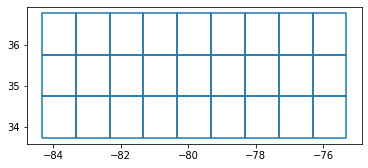

In [175]:
pixel_map = gpd.read_file('pixel_map.geojson')
pixel_map.boundary.plot();

In [160]:
def weighted_intersection(gdf1: gpd.GeoDataFrame, gdf1_idx: str, gdf2: gpd.GeoDataFrame, weight_str: str) \
        -> gpd.GeoDataFrame:
    # gdf1 is the gdf that contains the polygons into which we want to put information from gdf2
    # make sure gdf2 has an area column
    # intersect via overlay
    # see how much area the intersection has
    # find proportion of gdf2 area: intersection area"
    # make the propotion of gdf2 feature: intersection feature
    # sum the population
    
    
    # gdf1: geometry to fit into
    
    # gdf2: geometry to take from
        #   area of each geometry
        
    # intersection: area of geometry of gdf2
                #   area of intersected area
                #   proportion of intersected area to gdf2 area
                #   population contained in gdf2 polygon
                #   population contained in intersected area
    
    gdf1 = gdf1.to_crs(3857)
    gdf2 = gdf2.to_crs(3857)
    
    gdf2.insert(0, 'gdf2_num', range(len(gdf2)))
    
    if 'area' not in gdf2.columns:
        gdf2['area'] = gdf2.area
    
    inter = gpd.overlay(gdf1, gdf2, how='intersection')
    inter['inter_area'] = inter.area
    inter['gdf2_area'] = inter.apply(lambda row: gdf2.at[row['gdf2_num'], 'area'], axis=1)
    inter['prop ' + weight_str] = (inter['inter_area'] / inter['gdf2_area']) * inter[weight_str]
    inter = inter[['square_num', 'prop ' + weight_str]]
    
    groups = inter.groupby('square_num').sum()
    
    gdf1['attr'] = np.nan
    for row in groups.iterrows():
        square, attr = row
        attr = float(attr)
        gdf1.at[square, 'attr'] = attr
    
    
    return gdf1.rename(columns={'attr': gdf1_idx})

In [177]:
pixel_map.insert(0, 'square_num', range(len(pixel_map)))
population_map = weighted_intersection(pixel_map, 'population', nc_pop, 'population')

<AxesSubplot:>

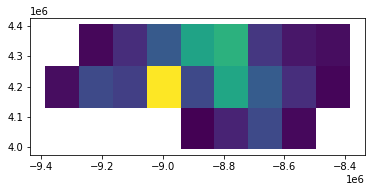

In [178]:
population_map.plot(column='population')

<AxesSubplot:>

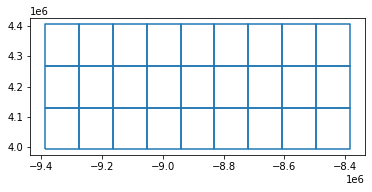

In [155]:
population_map.boundary.plot()

<AxesSubplot:>

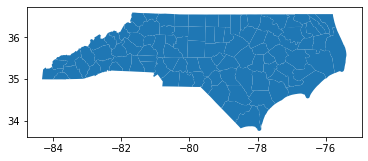

In [156]:
nc_pop.plot()

In [145]:
for idx, row in population_map.iterrows():
    print(float(row))
    print(idx)
#     square, pop = row
#     pop = float(pop)
#     print(pop)

16991.78705920604
4
211095.41107781845
5
464906.42772082984
6
58659.440152204974
7
85452.074589736
9
463748.31999879016
10
385999.13733485143
11
2005965.1492757122
12
458376.01221576193
13
1196030.9605349088
14
590943.7065409566
15
276391.5851019422
16
42559.441893263946
17
49373.49217887095
19
272146.9252194144
20
568860.4200808634
21
1169814.046015278
22
1290924.3566213753
23
331638.7213357752
24
134303.86791520848
25
81442.71713722851
26
